# Project: Trader Performance vs Market Sentiment

## Objective:
Analyze how market sentiment (Fear, Greed, etc.) influences trader performance using real-world execution data from Hyperliquid and the Bitcoin Fear & Greed Index.

We'll go through:
- Loading and cleaning both datasets
- Merging them on common date
- Analyzing patterns in profitability
- Bonus: a tiny machine learning model to predict outcomes

---

### Datasets:
- **fear_greed_index.csv**: Market sentiment per day
- **historical_data.csv**: Trader execution data



In [2]:
import pandas as pd

# Load Sentiment Data
sentiment_df = pd.read_csv("fear_greed_index.csv")
print("📊 Sentiment Data Sample:")
print(sentiment_df.head())

# Load Trader Data
trader_df = pd.read_csv("historical_data.csv")
print("\n📈 Trader Data Sample:")
print(trader_df.head())


📊 Sentiment Data Sample:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

📈 Trader Data Sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   


## Step 2: Clean the Sentiment Data

The sentiment dataset contains a daily classification like `Fear`, `Greed`, or `Extreme Fear`.

We’ll:
- Keep only the relevant columns (date and classification)
- Convert the date column to proper datetime format
- Preview the cleaned result


In [3]:
# Keep only the 'date' and 'classification' columns
sentiment_df = sentiment_df[['date', 'classification']]

#  Convert 'date' column to datetime format
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

#  Preview the cleaned data
print(sentiment_df.head())


        date classification
0 2018-02-01           Fear
1 2018-02-02   Extreme Fear
2 2018-02-03           Fear
3 2018-02-04   Extreme Fear
4 2018-02-05   Extreme Fear


/tmp/ipython-input-3-3221759591.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])


## Step 3: Prepare Trader Timestamps for Merging

The trader dataset includes a timestamp with both date and time (like "02-12-2024 22:50").  
To merge it with the sentiment data (which only has dates), we need to:

- Convert Timestamp IST to datetime format
- Extract only the date and store it in a new column
- Ensure the date format matches the sentiment dataset


In [4]:
# Convert 'Timestamp IST' to datetime format
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")

# Extract just the date part (discard time) into a new column
trader_df['date'] = trader_df['Timestamp IST'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])  # Ensure it's same format as sentiment_df

#  Check if it looks good
print(trader_df[['Timestamp IST', 'date']].head())


        Timestamp IST       date
0 2024-12-02 22:50:00 2024-12-02
1 2024-12-02 22:50:00 2024-12-02
2 2024-12-02 22:50:00 2024-12-02
3 2024-12-02 22:50:00 2024-12-02
4 2024-12-02 22:50:00 2024-12-02


## 🔗 Step 4: Merge Trader Data with Sentiment Labels

Now that both datasets have a common date column, we can combine them.

- We'll perform a **left join** to preserve all trader records
- Each trade will now be tagged with the market sentiment of that day


In [5]:
# Merge on 'date'
merged_df = pd.merge(trader_df, sentiment_df, on='date', how='left')

#  Preview the merged data
print(merged_df[['Timestamp IST', 'date', 'classification', 'Closed PnL']].head())


        Timestamp IST       date classification  Closed PnL
0 2024-12-02 22:50:00 2024-12-02  Extreme Greed         0.0
1 2024-12-02 22:50:00 2024-12-02  Extreme Greed         0.0
2 2024-12-02 22:50:00 2024-12-02  Extreme Greed         0.0
3 2024-12-02 22:50:00 2024-12-02  Extreme Greed         0.0
4 2024-12-02 22:50:00 2024-12-02  Extreme Greed         0.0


## Step 5: Analyze Trader Performance by Market Sentiment

Now that each trade has a sentiment label, we can:

- Group trades by sentiment (e.g., Fear, Greed)
- Calculate the **average Closed PnL** for each group
- Visualize how trader performance varies with market mood


In [6]:
#  Average Closed PnL by Sentiment Classification
avg_pnl_by_sentiment = merged_df.groupby('classification')['Closed PnL'].mean()
print(avg_pnl_by_sentiment)


classification
Extreme Fear     258.981881
Extreme Greed     59.224804
Fear             165.959508
Greed            103.639323
Neutral          105.904659
Name: Closed PnL, dtype: float64


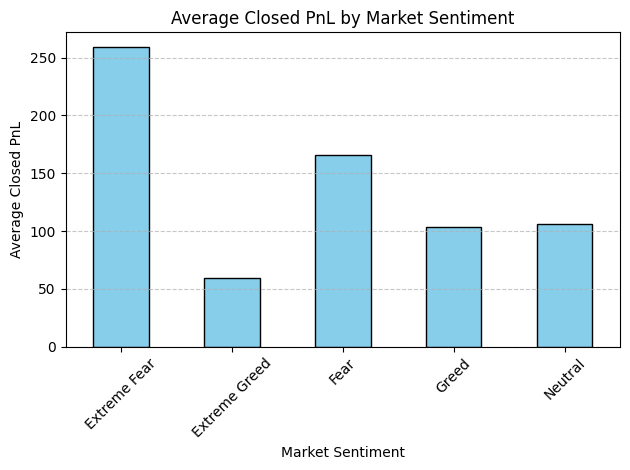

In [7]:
import matplotlib.pyplot as plt

# Bar Chart of Avg PnL by Sentiment
avg_pnl_by_sentiment.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Closed PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Step 6: Build a Simple ML Model to Predict Trade Profitability

We’ll train a basic Random Forest classifier to predict whether a trade will be **profitable or not**.

### Features:
- Market sentiment
- Side (Buy/Sell)
- Execution Price
- Trade Size
- Fee

### Target:
- 1 if Closed PnL > 0, else 0


## PnL Distribution by Market Sentiment

This boxplot shows the **spread and skew** of trader profits (PnL) across different market sentiment states.  
It helps reveal whether traders generally perform better in Fear, Greed, or Neutral conditions.


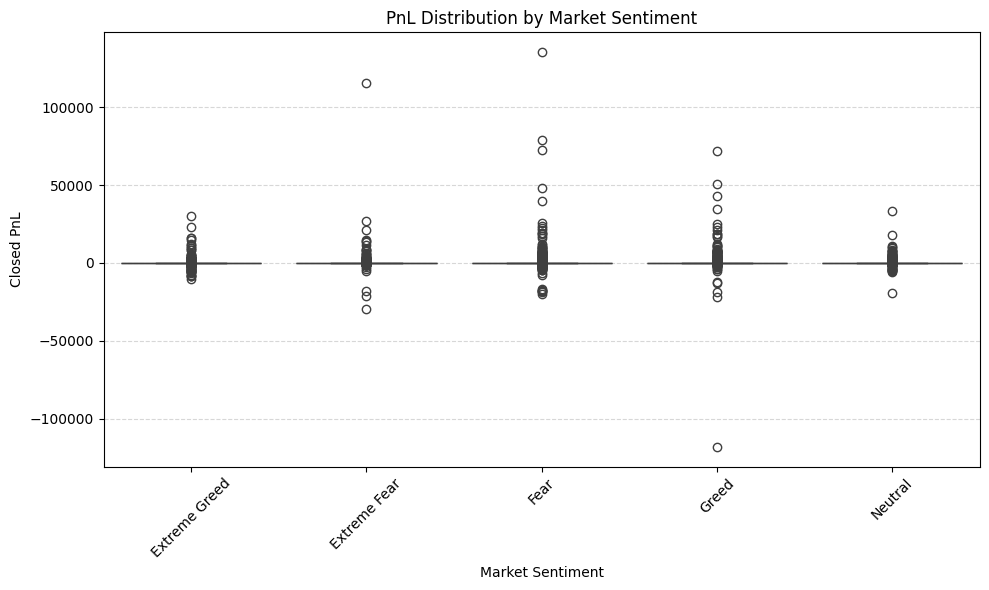

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='Closed PnL', data=merged_df)
plt.title('PnL Distribution by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Market Sentiment Over Time

This chart shows how the frequency of each sentiment label (Fear, Greed, etc.) changes over time.  
Useful to understand **macro mood shifts** in the crypto market.


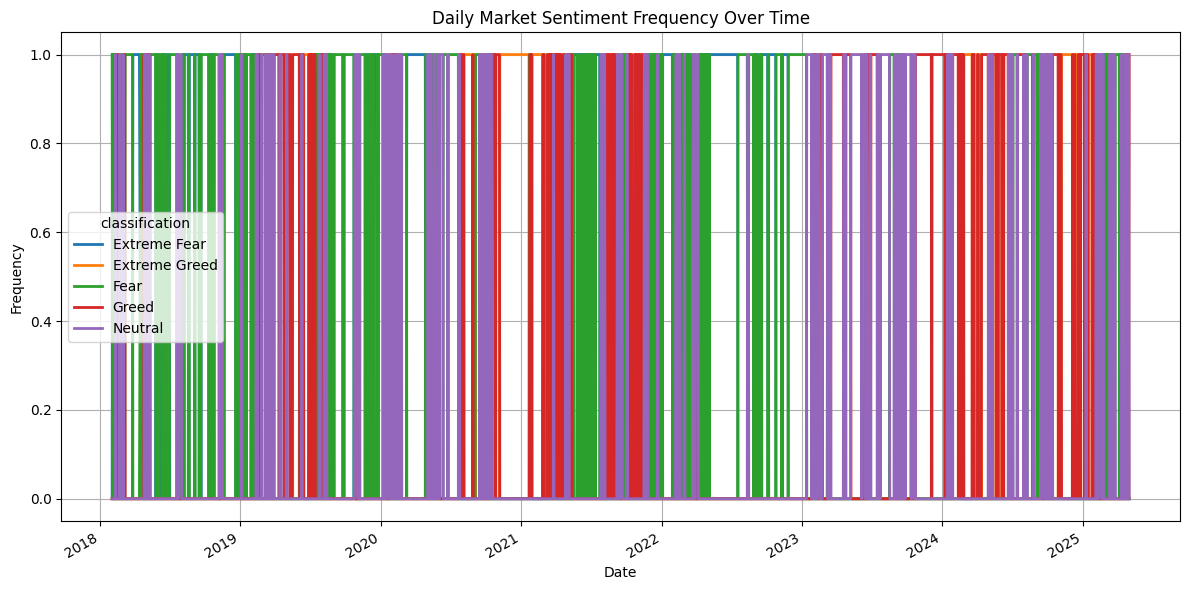

In [11]:
# Count of each sentiment per day
sentiment_count = sentiment_df.groupby(['date', 'classification']).size().unstack().fillna(0)

# Plot time-series trend
sentiment_count.plot(figsize=(12, 6), linewidth=2)
plt.title('Daily Market Sentiment Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Correlation Heatmap

This heatmap shows how features like execution price, trade size, and fee relate to each other and to PnL.  
It’s a great way to **spot multicollinearity** or strong relationships before modeling.


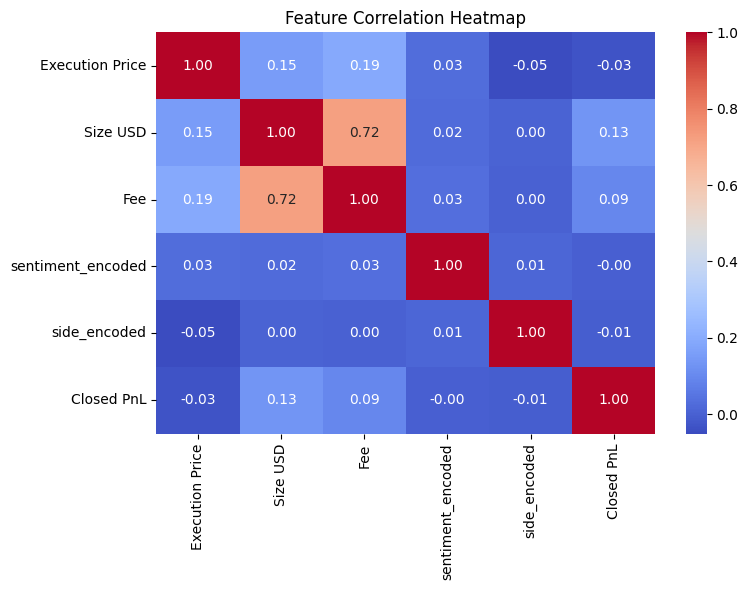

In [12]:
corr = df[['Execution Price', 'Size USD', 'Fee', 'sentiment_encoded', 'side_encoded', 'Closed PnL']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 🧹 Remove rows with missing sentiment
df = merged_df.dropna(subset=['classification']).copy()

# 🎯 Target: 1 = profit, 0 = loss
df['label'] = df['Closed PnL'] > 0

# 🔢 Encode categorical variables
df['sentiment_encoded'] = df['classification'].astype('category').cat.codes
df['side_encoded'] = df['Side'].astype('category').cat.codes
df['Fee'] = df['Fee'].fillna(0)  # Fill missing fees if any

# 🧠 Features & Labels
X = df[['Execution Price', 'Size USD', 'Fee', 'sentiment_encoded', 'side_encoded']]
y = df['label']

# 🧪 Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🎯 Train Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔍 Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Accuracy: {accuracy:.2%}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))


✅ Accuracy: 93.61%

📋 Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.94      0.94      3770
        True       0.92      0.93      0.92      2739

    accuracy                           0.94      6509
   macro avg       0.93      0.93      0.93      6509
weighted avg       0.94      0.94      0.94      6509



## Rolling Volatility of Closed PnL

We calculate the rolling standard deviation of PnL to measure **volatility**, a key concept in trading risk.  
This reveals how risky trader outcomes were during different market sentiment phases.


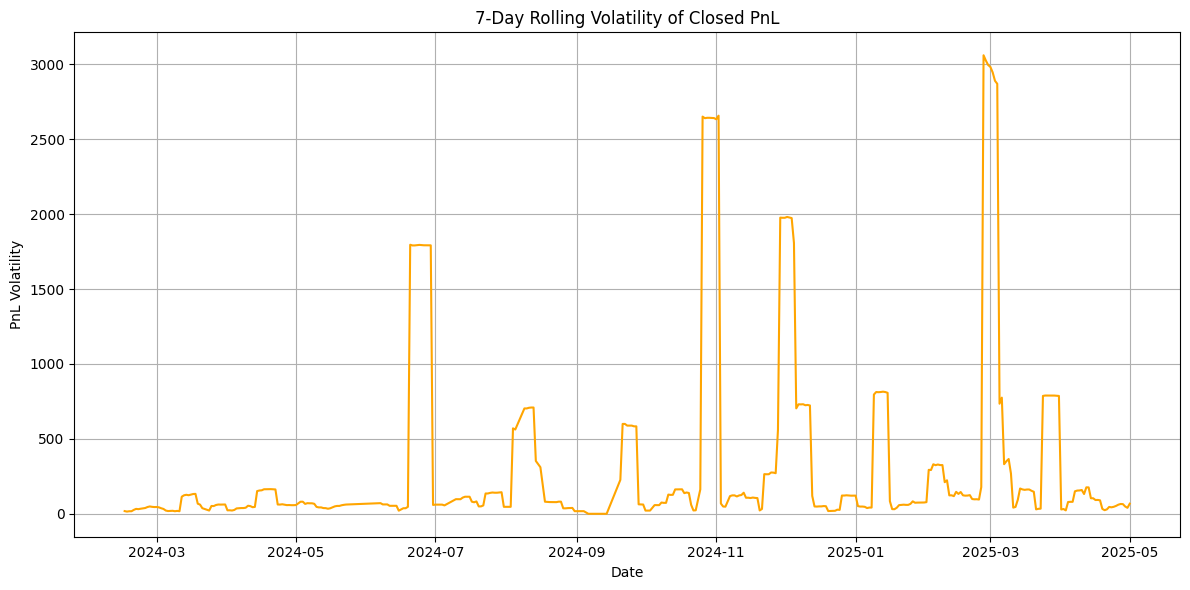

In [13]:
# Resample to daily average PnL
daily_pnl = merged_df.groupby('date')['Closed PnL'].mean()

# Calculate rolling 7-day volatility
rolling_volatility = daily_pnl.rolling(window=7).std()

plt.figure(figsize=(12,6))
plt.plot(rolling_volatility, color='orange')
plt.title('7-Day Rolling Volatility of Closed PnL')
plt.xlabel('Date')
plt.ylabel('PnL Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()


## Insight: Fear Seems to Bring Opportunity

Trades during "Extreme Fear" days had the **highest average PnL**.

This aligns with the crypto mantra:
> *"Be greedy when others are fearful." – Warren Buffett*

Could sentiment be used as a **contrarian signal** for automated entries?


## Bonus Feature: Lagged Sentiment (Previous Day)

To simulate how past market mood may affect today's trading outcomes, we create a lagged feature for yesterday’s sentiment.


In [17]:
# Step 1: Create lagged sentiment in the original sentiment dataframe
sentiment_lag_df = sentiment_df.copy()
sentiment_lag_df['sentiment_lag'] = sentiment_lag_df['classification'].shift(1)

# Step 2: Merge lagged sentiment into the main merged_df using 'date'
merged_df = pd.merge(merged_df, sentiment_lag_df[['date', 'sentiment_lag']], on='date', how='left')

# Step 3: Encode lagged sentiment
merged_df['sentiment_lag_encoded'] = merged_df['sentiment_lag'].astype('category').cat.codes

# Preview new columns
print(merged_df[['date', 'classification', 'sentiment_lag', 'sentiment_lag_encoded']].head())


        date classification  sentiment_lag  sentiment_lag_encoded
0 2024-12-02  Extreme Greed  Extreme Greed                      1
1 2024-12-02  Extreme Greed  Extreme Greed                      1
2 2024-12-02  Extreme Greed  Extreme Greed                      1
3 2024-12-02  Extreme Greed  Extreme Greed                      1
4 2024-12-02  Extreme Greed  Extreme Greed                      1
